In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import tensorflow as tf
import tensornetwork
from tensornetwork import ncon
import seaborn as sns
net = tensornetwork.TensorNetwork()
sess = tf.InteractiveSession()

# Matrix Product State (MPS) o tensor train (TT)
​
<img src="http://tensornetwork.org/mps/mpstt_diagram.png" width="400">
​
*    Es la factorizacion de un tensor con N indices en un producto tipo cadena lineal de tensores de tres índices. 
​
*    Es un caso especial de una red tensorial de árbol.
​
*    <br>
<img src="https://tensornetwork.org/mps/bond_external_dim.png" width="300">
<br>
$d^N$ = Numero de parametros de tensor $T$ de orden $N$ y dimension local $d$ 
<br>
$Ndm^2$ $\ge$ Numero de parametros de representacion MPS de $T$ (seria igual si el rango interno fuera el mismo en todo el MPS)

# Descomposicion MPS/TT-SVD

<img src="https://drive.google.com/uc?export=view&id=1TOe1YsvrTCLGHX3M5k7xPPSwmi16bbTi" width="500">
<br>
<img src="https://drive.google.com/uc?export=view&id=1DSBfh1BoXruSJlJbdSMQ2DQKKw5zPBih" width="400">


In [2]:
##### Descomposicion de tensor de 4 indices a MPS usando SVD truncado con ortogonalidad izquierda
d = 30 # dimension externa
H0 = net.add_node(np.random.rand(d,d,d,d)) 
H0 = net.add_node(H0.tensor/tf.norm(H0.tensor))
eps = 0.1
deltaval=eps/np.sqrt(4-1)

# primera descomposicion
u0,s,vh,trun_err = net.split_node_full_svd(H0,[H0[0]],[H0[1],H0[2],H0[3]],None,deltaval)
H1 = net.add_node(ncon([s.tensor,vh.tensor],[[-1,1],[1,-2,-3,-4]]))
print("u0: ",u0.tensor.shape,"s0: ",s.tensor.shape,"vh0: ",vh.tensor.shape)
print("H1: ",H1.tensor.shape)
# segunda descomposicion
u1,s,vh,trun_err = net.split_node_full_svd(H1,[H1[0],H1[1]],[H1[2],H1[3]],None,deltaval)
H2 = net.add_node(ncon([s.tensor,vh.tensor],[[-1,1],[1,-2,-3]]))
print("u1: ",u1.tensor.shape,"s1: ",s.tensor.shape,"vh1: ",vh.tensor.shape)
print("H2: ",H2.tensor.shape)
# tercera descomposicion
u2,s,vh,trun_err = net.split_node_full_svd(H2,[H2[0],H2[1]],[H2[2]],None,deltaval)
H3 = net.add_node(ncon([s.tensor,vh.tensor],[[-1,1],[1,-2]])) 
print("u2: ",u2.tensor.shape,"s2: ",s.tensor.shape,"vh2: ",vh.tensor.shape)
print("H3: ",H3.tensor.shape)

#verificar
H0recovered = net.add_node(ncon([u0.tensor,u1.tensor,u2.tensor,H3.tensor],[[-1,1],[1,-2,2],[2,-3,3],[3,-4]]))
print("totErr = ",(tf.norm(H0recovered.tensor-H0.tensor)/tf.norm(H0.tensor)).eval())

u0:  (30, 30) s0:  (30, 30) vh0:  (30, 30, 30, 30)
H1:  (30, 30, 30, 30)
u1:  (30, 30, 673) s1:  (673, 673) vh1:  (673, 30, 30)
H2:  (673, 30, 30)
u2:  (673, 30, 30) s2:  (30, 30) vh2:  (30, 30)
H3:  (30, 30)
totErr =  0.05764783525841739


# Operaciones elementales con MPS/TT

  
###    Producto interno o superposicion de dos MPS/TT
<img src="http://tensornetwork.org/mps/TdotW.png" width="200">
<br>
<img src="http://tensornetwork.org/mps/TW_MPSTT.png" width="250">
<br>
<img src="http://tensornetwork.org/mps/InnerMPSTT.png" width="250">
  
###    Compresion o redondeo
  
<img src="http://tensornetwork.org/mps/mpstt_compress.png" width="400">

## Solucion de ecuaciones lineales $Ax=\lambda x$ o $Ax=b$ por medio de DMRG

### Planteamiento del problema

*  Considere un operador $H$ de orden $N$, con dimensiones locales $d$
<br>
<img src="https://tensornetwork.org/mps/algorithms/dmrg/H_diagram.png" width="400">
<br>
*  El algoritmo DMRG busca el eigenvector dominante de $H$ en la forma MPS, donde $E_0$ ($\le E_1\le E_2$...) es el menor valor propio de $H$
<br>
<img src="https://tensornetwork.org/mps/algorithms/dmrg/H_eigenvector.png" width="400">
<br>
*  Para que el algoritmo sea eficiente $H$ debe estar en la forma MPO
<br>
<img src="https://tensornetwork.org/mps/algorithms/dmrg/H_MPO_form.png" width="400">

### Pasos del algoritmo DMRG

#### Paso 0: Preparacion

*  Llevar al MPS inicial a una forma ortogonal (Aqui escogemos que sea ortogonal a derecha)
<br>
<img src="https://tensornetwork.org/mps/algorithms/dmrg/right_ortho_MPS.png" width="400">
<br>
*  Por la propiedad de ortogonalizacion a derecha, podemos interpretar los tensores MPS 3,4,... colectivamente como un cambio de base desde la base de indices locales $i_3$,$i_4$,... a la de indice de enlace $\alpha_2$
<br>
<img src="https://tensornetwork.org/mps/algorithms/dmrg/MPS_change_of_basis.png" width="400">
<br>
*  Esta interpretacion motiva a la transformacion de $H$ a la base $i_1$,$i_2$,$\alpha_2$ 
<br>
<img src="https://tensornetwork.org/mps/algorithms/dmrg/projected_H.png" width="400">
<br>
*  Tomando $H$ como MPO, podemos calcular la transformacion eficientemente, definiendo los tensores $R_j$ por el camino
<br>
<img src="https://tensornetwork.org/mps/algorithms/dmrg/H_edge.png" width="400">
<br>
*  Por eficiencia, Es crucial que los tensores de borde $R_j$ se creen contrayendo cada tensor MPS o MPO uno a la vez en un cierto orden
<br>
<img src="https://tensornetwork.org/mps/algorithms/dmrg/H_edge_ordering.png" width="400">
<br>
*  Luego, contraemos los dos primeros tensores MPS
<br>
<img src="https://tensornetwork.org/mps/algorithms/dmrg/bond1.png" width="400">
<br>

# Clasificacion de imagenes MNIST

In [3]:
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()


Using TensorFlow backend.


In [4]:
X_train = X_train.reshape(len(X_train), 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

There are 60000 training data and 10000 testing data.
Number of occurence for each number in training data (0 stands for 10):
[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]


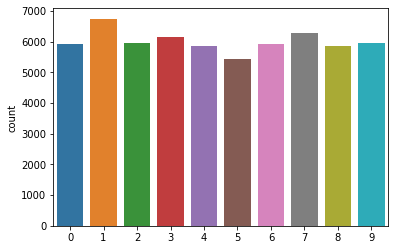

In [5]:
# normalization
X_train = np.array(X_train) / 255.
Y_train = np.array(Y_train)
X_test = np.array(X_test) / 255.
Y_test = np.array(Y_test)
#X_valid = np.array(X_valid) / 255.
#Y_valid = np.array(Y_valid)

print('There are', X_train.shape[0], 'training data and',  X_test.shape[0], 'testing data.')
print('Number of occurence for each number in training data (0 stands for 10):')
print(np.vstack((np.unique(Y_train), np.bincount(Y_train))).T)
sns.countplot(Y_train)

In [6]:
print(np.shape(X_train))

(60000, 28, 28, 1)


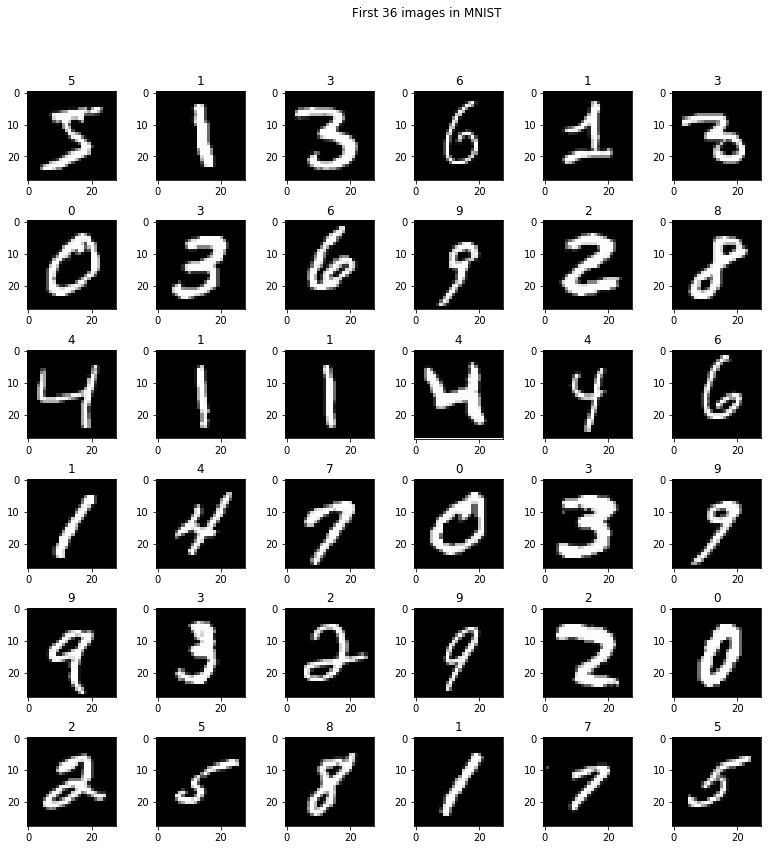

In [7]:
# plot first 36 images in MNIST
fig, ax = plt.subplots(6, 6, figsize = (12, 12))
fig.suptitle('First 36 images in MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(6) for j in range(6)]:
    ax[x, y].imshow(X_train[x + y * 6].reshape((28, 28)), cmap = 'gray')
    ax[x, y].set_title(Y_train[x + y * 6])

In [8]:
Y_train[0]

5

In [9]:
from keras.utils import to_categorical

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [10]:
print(Y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
